# Speech Classifcation + CNN 2D with torch Audio

## Signals
A signal is a variation in a certain quantity over time. For audio, the quantity that varies is air pressure. How do we capture this information digitally? We can take samples of the air pressure over time. The rate at which we sample the data can vary, but is most commonly 44.1kHz, or 44,100 samples per second. What we have captured is a waveform for the signal, and this can be interpreted, modified, and analyzed with computer software.

## The Fourier Transform

The Fourier transform is a mathematical tool that decomposes a complex signal into its constituent sine waves. Although an audio signal is built from multiple single-frequency tones, the time-domain recording only captures their combined amplitudes. By applying the `Fourier transform`, we convert this `time-domain data` into the `frequency domain`, revealing the individual frequencies and their amplitudes—a representation known as the `spectrum`.

The fast Fourier transform (FFT) is an algorithm that can efficiently compute the Fourier transform. It is widely used in signal processing. I will use this algorithm on a windowed segment of our example audio.

<img src="../figures/FT.webp" >

## The Spectrogram

The fast Fourier transform (FFT) is excellent for revealing the frequency content of a signal. However, many real-world signals—like music or speech—change over time, meaning their frequency content isn’t constant. These are known as non-periodic signals. To capture how the spectrum evolves, we divide the signal into overlapping, windowed segments and perform an FFT on each one. This method, known as the short-time Fourier transform, produces a sequence of spectra that, when displayed together, form a spectrogram—a visual representation of the frequency changes over time.

<img src="../figures/Spectrogram.webp" >

## The Mel Scale

Humans don't perceive frequencies linearly; our ears are more sensitive to changes at lower frequencies than at higher ones. For instance, while the difference between 500 Hz and 1000 Hz is quite noticeable, a similar gap between 10,000 Hz and 10,500 Hz is hardly detectable. In 1937, Stevens, Volkmann, and Newmann introduced a pitch unit where equal intervals in pitch sounded equally spaced to the listener. This concept is known as the mel scale, and we convert standard frequencies to the mel scale through a mathematical transformation.

<img src="../figures/MelScale.gif" >

## MFCC vs Mel Spectrogram: A Quick Comparison

**Mel Spectrogram**:
- A time-frequency representation of audio.
- Uses **Fourier Transform** and a **Mel filter bank** to map frequencies to the Mel scale.
- Often applies **logarithmic scaling** for amplitude.
- Useful for tasks like sound classification and speech recognition where detailed time-frequency info is needed.

**MFCC (Mel-Frequency Cepstral Coefficients)**:
- A compressed version of the Mel Spectrogram.
- Derived by applying a **Discrete Cosine Transform (DCT)** after Mel scaling.
- Focuses on capturing **speech-related features** while reducing dimensionality.
- Common in **speech recognition** and audio classification.

**Key Differences**:
1. **Representation**: 
   - **Mel Spectrogram**: Detailed time-frequency map.
   - **MFCC**: Compact, feature-rich coefficients.
   
2. **Application**:
   - **Mel Spectrogram**: Used for tasks needing time-frequency details (e.g., sound event detection).
   - **MFCC**: Used for tasks needing compact features (e.g., speech recognition).

3. **Dimensionality**:
   - **Mel Spectrogram**: Higher-dimensional.
   - **MFCC**: Lower-dimensional, more efficient.

**Summary**: Use **Mel Spectrograms** for detailed frequency analysis and **MFCCs** for more efficient feature extraction in speech or audio recognition tasks.

In [1]:
# pip install torchaudio
# pip install librosa

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio
import os
from tqdm import tqdm
import torchaudio.transforms as T
from torch.utils.data import DataLoader, random_split, Dataset
# Set GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Dataset

In [3]:
dataset = torchaudio.datasets.SPEECHCOMMANDS(
    './datasets/', 
    url = 'speech_commands_v0.02', 
    folder_in_archive = 'SpeechCommands',  
    download = True
)
# FYI : Speech Commands is an audio dataset of spoken words designed to help train and evaluate keyword spotting systems .

In [4]:
dataset.get_metadata(1)

('speech_commands_v0.02/backward/017c4098_nohash_0.wav',
 16000,
 'backward',
 '017c4098',
 0)

In [5]:
# len(raw_dataset)

## Visualization & Pre-processing

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


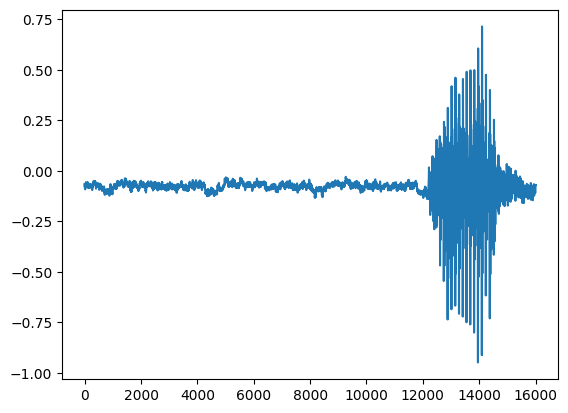

In [6]:
filename = "./datasets/SpeechCommands/speech_commands_v0.02/backward/0165e0e8_nohash_0.wav"
waveform, sample_rate = torchaudio.load(filename, normalize=True)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

# To play the audio
Audio(filename)

In [7]:
import os
audio_path = './datasets/SpeechCommands/speech_commands_v0.02/'
labels_dict = os.listdir(audio_path)
len(labels_dict)

42

In [8]:
wave, _, _, _, _ = dataset[50000]

### 1D vs. 2D CNN Approaches for Speech Recognition

Both **1D** and **2D** convolutional neural network (CNN) approaches have their merits. The choice between them depends on your specific application, accuracy requirements, and computational constraints.

---

#### 2D CNNs on Spectrograms

- **Richer Acoustic Information:**  
  - Converting raw audio into time–frequency representations (such as spectrograms) captures detailed acoustic features similar to how the human ear processes sound.

- **High Recognition Accuracy:**  
  - Studies have shown that 2D CNN–LSTM networks can achieve very high recognition accuracies. For instance, one paper reported accuracies of around **95%** on the Berlin EmoDB dataset

- **Ideal for Accuracy-Centric Applications:**  
  - This approach is preferred when maximizing accuracy is the priority and the extra pre-processing (to generate spectrograms) is acceptable.

---

#### 1D CNNs on Raw Waveforms

- **Simpler Pipeline:**  
  - Operates directly on the raw audio signal, eliminating the need for a time–frequency transformation.

- **Computational Efficiency:**  
  - Can be more computationally efficient and may converge faster, making it ideal for real-time applications or scenarios with limited resources.

- **Good for Simpler Tasks:**  
  - Suitable when you want a less complex model that avoids the overhead of additional pre-processing.

---

#### Summary

- **Choose 2D CNNs** if:
  - You want to leverage detailed time–frequency information.
  - Maximum recognition accuracy is required.
  - You can handle the additional pre-processing overhead.

- **Choose 1D CNNs** if:
  - You need a simpler, faster, and more resource-friendly solution.
  - Real-time processing is a priority.

---

*Note: The reference [🔗cite:turn0search17] points to a study that demonstrated high accuracy (95.33% and 95.89% in speaker-dependent and speaker-independent experiments, respectively) using a 2D CNN-LSTM network on speech emotion recognition tasks.*

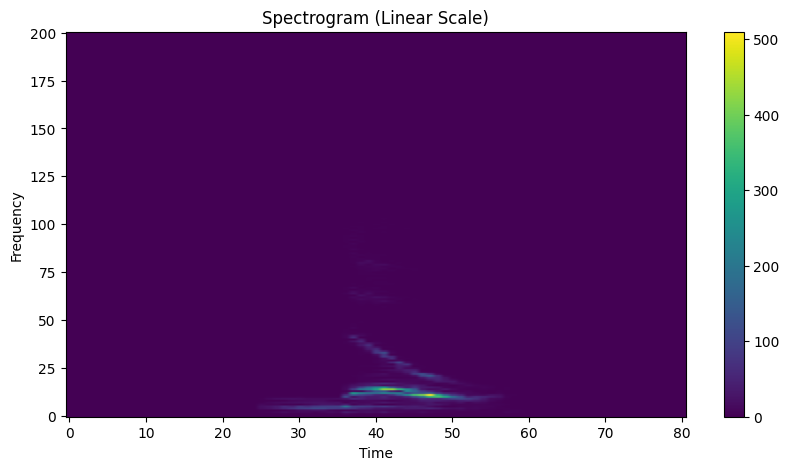

In [9]:
import torchaudio
import matplotlib.pyplot as plt

# Ensure that 'wave' is your audio waveform tensor.
# For example, you might load an audio file as follows:
# wave, sample_rate = torchaudio.load("your_audio_file.wav")

### 1. Compute and plot a basic Spectrogram (linear scale)
# This uses the short-time Fourier transform (STFT) to generate a spectrogram.
spectrogram_transform = torchaudio.transforms.Spectrogram()
spec = spectrogram_transform(wave)

plt.figure(figsize=(10, 5))
plt.imshow(spec[0, :, :].numpy(), origin='lower', aspect='auto')
plt.title("Spectrogram (Linear Scale)")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [10]:
spec.shape

torch.Size([1, 201, 81])

/home/todsavadt/.local/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


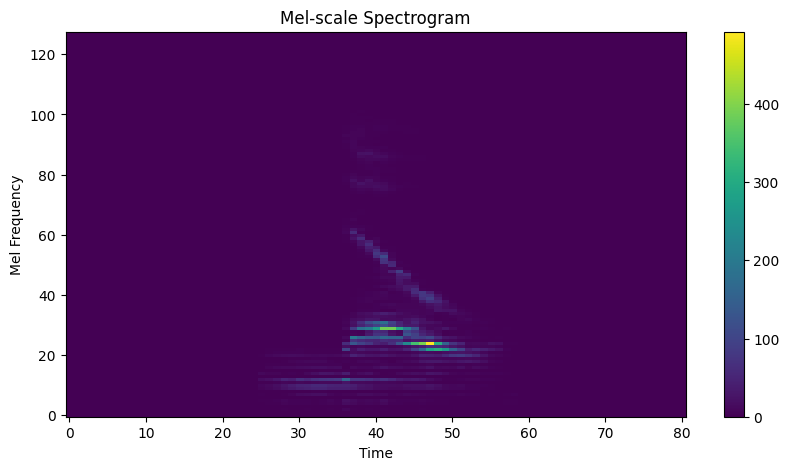

In [11]:
### 2. Compute and plot a Mel-scale Spectrogram
# The Mel-scale spectrogram maps frequencies to the Mel scale, 
# which better approximates the human ear's response to different frequencies.
mel_spec_transform = torchaudio.transforms.MelSpectrogram()
mel_spec = mel_spec_transform(wave)

plt.figure(figsize=(10, 5))
plt.imshow(mel_spec[0, :, :].numpy(), origin='lower', aspect='auto')
plt.title("Mel-scale Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.colorbar()
plt.show()

In [12]:
mel_spec.shape

torch.Size([1, 128, 81])

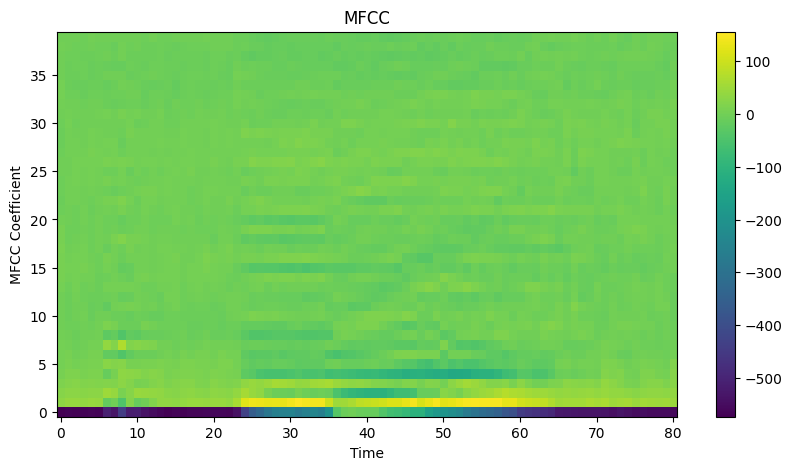

In [13]:
### 3. Compute and plot MFCC (Mel Frequency Cepstral Coefficients)
# MFCCs provide a compact representation of the spectral envelope,
# which is useful in many audio processing and speech recognition tasks.
mfcc_transform = torchaudio.transforms.MFCC()
mfcc = mfcc_transform(wave)

plt.figure(figsize=(10, 5))
plt.imshow(mfcc[0, :, :].numpy(), origin='lower', aspect='auto')
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficient")
plt.colorbar()
plt.show()

In [14]:
mfcc.shape

torch.Size([1, 40, 81])

## Which one is the best

There isn’t a one-size-fits-all “best” representation—it all depends on your application and what aspects of the audio signal you need to capture. Here’s a quick breakdown:

- **Spectrogram (Linear Scale):**  
  Provides a full view of frequency content. It’s useful when you want all the details of the signal’s frequency structure. However, its representation might include information that’s not perceptually relevant for human hearing.

- **Mel-scale Spectrogram:**  
  Maps the frequencies to the Mel scale, which better reflects how humans perceive sound. This representation emphasizes lower frequencies (which are generally more important for speech and music) and is often used in tasks like music analysis or when a perceptually-relevant view of the spectrum is needed.

- **MFCC (Mel Frequency Cepstral Coefficients):**  
  These are a compact representation that summarizes the spectral envelope of the audio. MFCCs have historically been popular in speech recognition because they capture the timbral aspects of sound effectively while reducing the dimensionality of the data.

### Which One Should You Use?

- **For Speech Recognition:**  
  MFCCs have been widely used because they capture the most relevant features of speech in a compact form. However, many modern deep learning approaches now use Mel spectrograms or even raw waveforms.

- **For Music Analysis or Tasks Requiring Detailed Frequency Information:**  
  A Mel-scale spectrogram may be more suitable as it provides a balance between detailed frequency information and human perceptual relevance.

- **For General Audio Analysis:**  
  A full spectrogram might be beneficial if you need all available frequency details, though it might require additional processing to focus on perceptually important features.

Ultimately, the “best” method depends on the specific requirements of your task, including factors like the type of audio, computational resources, and the performance of your downstream model or analysis.

## Dataloader

In [16]:
# Define the custom Dataset for handling audio and labels
class SpeechCommandsDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.class_names = sorted(set(item[2] for item in dataset))  # unique labels

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        waveform, sample_rate, label, _, _ = self.dataset[index]
        
        # Move the waveform to the same device as the transform
        waveform = waveform.to(device)
        
        # Apply the Mel Spectrogram transform
        if self.transform:
            waveform = self.transform(waveform)
        
        # Convert the label to an integer (class index)
        label_idx = self.class_names.index(label)

        return waveform, label_idx

# Define the MelSpectrogram transform
# transform = T.MelSpectrogram(sample_rate=16000, n_mels=64).to(device)
transform = T.MFCC(sample_rate=16000, n_mfcc=64).to(device)

# Create the custom dataset with Mel Spectrogram transform
raw_dataset = SpeechCommandsDataset(dataset, transform=transform)

# Split the dataset into training and test sets
traindata, testdata = random_split(raw_dataset, [round(len(raw_dataset) * 0.8), round(len(raw_dataset) * 0.2)])

In [17]:
import torch.nn.functional as F

def pad_collate_fn(batch):
    """
    Pads each Mel spectrogram in the batch to the maximum time dimension.
    
    Args:
        batch: List of tuples (mel_spectrogram, label)
    Returns:
        Tuple (padded_mel_batch, labels)
    """
    # Get maximum time dimension length in the batch
    max_len = max(item[0].shape[-1] for item in batch)
    
    padded_mels = []
    labels = []
    for mel, label in batch:
        # Calculate padding length (pad on the right)
        pad_length = max_len - mel.shape[-1]
        # Pad the time dimension (last dimension)
        mel_padded = F.pad(mel, (0, pad_length))  # (pad_left, pad_right)
        padded_mels.append(mel_padded)
        labels.append(label)
    
    # Stack padded tensors into a single batch tensor
    padded_mels = torch.stack(padded_mels)
    labels = torch.tensor(labels)
    
    return padded_mels, labels

In [18]:
train_loader = DataLoader(
    traindata, 
    batch_size=128, 
    shuffle=True,
    collate_fn=pad_collate_fn
)
test_loader = DataLoader(
    testdata,  
    batch_size=128, 
    shuffle=False,
    collate_fn=pad_collate_fn
)

In [21]:
for waveform, out_label in train_loader:
    break

In [22]:
waveform.shape, out_label.shape

(torch.Size([128, 1, 64, 81]), torch.Size([128]))

## Model

In [24]:
class KeywordSpottingModel(nn.Module):
    def __init__(self, num_classes):
        super(KeywordSpottingModel, self).__init__()
        # Convolutional block 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        # Convolutional block 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        # Convolutional block 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        
        # Pooling layers (using max pooling to reduce spatial dimensions)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Adaptive pooling to obtain a fixed-size output regardless of T dimension
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.3)
        
        # Final fully-connected layer for classification
        self.fc = nn.Linear(64, num_classes)
    
    def forward(self, x):
        # Input x shape: [batch_size, 1, 64, T]
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # shape: [B, 16, 32, T/2]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # shape: [B, 32, 16, T/4]
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # shape: [B, 64, 8, T/8]
        x = self.adaptive_pool(x)  # shape: [B, 64, 1, 1]
        x = x.view(x.size(0), -1)  # flatten to [B, 64]
        x = self.dropout(x)
        x = self.fc(x)  # shape: [B, num_classes]
        return x

# Example usage:
# Assume `raw_dataset` is the instance of SpeechCommandsDataset.
# Get the number of classes from your dataset:
num_classes = len(raw_dataset.class_names)
model = KeywordSpottingModel(num_classes=num_classes)
model.to(device)

KeywordSpottingModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=35, bias=True)
)

In [25]:
n = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {n}")

Number of parameters: 25795


In [26]:
# Testing the model with a dummy batch from your DataLoader:
for mel_batch, labels in train_loader:
    # mel_batch has shape [B, 1, 64, T]
    outputs = model(mel_batch)
    print("Output shape:", outputs.shape)  # Should be [B, num_classes]
    break

Output shape: torch.Size([128, 35])


## Train & Test

In [27]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)

# Initialize ReduceLROnPlateau
# mode='min' because we're monitoring loss, factor=0.1 reduces LR by a factor of 10,
# patience=5 means wait for 5 epochs with no improvement before reducing the LR.
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# reduce the learning after 20 epochs by a factor of 10

In [28]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

In [29]:
losses = [] 
def train(model, train_loader, optim, criterion, epoch, device):
    print("Training")
    model.train()
    train_loss = 0
    total = 0
    total_correct = 0
    
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optim.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,targets)
        loss.backward()
        optim.step()
        
        train_loss += loss.item()
        # record loss
        losses.append(loss.item())
        _, predicted = torch.max(outputs.data,1)
        total_correct += (predicted == targets).sum().item()
        total += targets.size(0)
        
    # scheduler.step()
    print("Loss: {:.2f} Accuracy: {:.2f}".format(train_loss/len(train_loader), total_correct*100/total))

In [30]:
def test(model, test_loader, optim, criterion, epoch, device, model_name="weight"):
    global best_acc
    print("validation")
    model.eval()
    test_loss, total, total_correct = 0,0,0
    
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        total_correct += (predicted == targets).sum().item()

    # Save checkpoint when best model
    acc = 100. * total_correct / total
    print("Loss: %.4f Acc@1: %.2f%%" %(test_loss/len(test_loader), acc))
    
    if acc > best_acc:
        if isinstance(model, torch.nn.DataParallel):
            # print("multiple GPU")
            # print('Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
            state = {
                'model':model.module.state_dict(),
                'model1': model.state_dict(),
                'model2': model,
                'acc':acc,
                'epoch':epoch,
            }
        
        else:
            # print("not multiple GPU")
            state = {
                    'model':model,
                    'acc':acc,
                    'epoch':epoch,
                    }      
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        save_point = './checkpoint/'
        if not os.path.isdir(save_point):
            os.mkdir(save_point)
        torch.save(state, save_point + model_name+'.t7')
        best_acc = acc
        
    return best_acc

In [31]:
num_epochs = 15
best_acc   = 0

for epoch in range(0, num_epochs):
    print(f"Epoch: {epoch+1}" )
    train(model,train_loader, optimizer, criterion, epoch, device)
    best_acc = test(model, test_loader, optimizer, criterion, epoch, device)

Epoch: 1
Training


100%|██████████| 662/662 [01:06<00:00,  9.96it/s]


Loss: 3.04 Accuracy: 18.93
validation


100%|██████████| 166/166 [00:16<00:00, 10.20it/s]


Loss: 2.5566 Acc@1: 38.60%
Epoch: 2
Training


100%|██████████| 662/662 [01:06<00:00,  9.91it/s]


Loss: 2.30 Accuracy: 38.52
validation


100%|██████████| 166/166 [00:15<00:00, 10.40it/s]


Loss: 1.9136 Acc@1: 54.39%
Epoch: 3
Training


100%|██████████| 662/662 [01:07<00:00,  9.84it/s]


Loss: 1.83 Accuracy: 50.46
validation


100%|██████████| 166/166 [00:15<00:00, 10.47it/s]


Loss: 1.5612 Acc@1: 59.85%
Epoch: 4
Training


100%|██████████| 662/662 [01:07<00:00,  9.79it/s]


Loss: 1.56 Accuracy: 57.08
validation


100%|██████████| 166/166 [00:16<00:00, 10.16it/s]


Loss: 1.3049 Acc@1: 67.64%
Epoch: 5
Training


100%|██████████| 662/662 [01:07<00:00,  9.86it/s]


Loss: 1.38 Accuracy: 61.92
validation


100%|██████████| 166/166 [00:15<00:00, 10.41it/s]


Loss: 1.1235 Acc@1: 72.12%
Epoch: 6
Training


100%|██████████| 662/662 [01:07<00:00,  9.85it/s]


Loss: 1.26 Accuracy: 64.80
validation


100%|██████████| 166/166 [00:15<00:00, 10.57it/s]


Loss: 1.0773 Acc@1: 71.53%
Epoch: 7
Training


100%|██████████| 662/662 [01:06<00:00,  9.89it/s]


Loss: 1.16 Accuracy: 67.13
validation


100%|██████████| 166/166 [00:16<00:00, 10.24it/s]


Loss: 0.9862 Acc@1: 73.33%
Epoch: 8
Training


100%|██████████| 662/662 [01:06<00:00, 10.02it/s]


Loss: 1.09 Accuracy: 69.17
validation


100%|██████████| 166/166 [00:16<00:00, 10.16it/s]


Loss: 0.9580 Acc@1: 74.59%
Epoch: 9
Training


100%|██████████| 662/662 [01:06<00:00,  9.95it/s]


Loss: 1.04 Accuracy: 70.62
validation


100%|██████████| 166/166 [00:16<00:00, 10.16it/s]


Loss: 0.8746 Acc@1: 77.08%
Epoch: 10
Training


100%|██████████| 662/662 [01:07<00:00,  9.87it/s]


Loss: 0.99 Accuracy: 71.85
validation


100%|██████████| 166/166 [00:16<00:00, 10.32it/s]


Loss: 0.8244 Acc@1: 77.83%
Epoch: 11
Training


100%|██████████| 662/662 [01:07<00:00,  9.88it/s]


Loss: 0.95 Accuracy: 72.71
validation


100%|██████████| 166/166 [00:15<00:00, 10.46it/s]


Loss: 0.8017 Acc@1: 79.04%
Epoch: 12
Training


100%|██████████| 662/662 [01:07<00:00,  9.85it/s]


Loss: 0.92 Accuracy: 73.76
validation


100%|██████████| 166/166 [00:16<00:00, 10.24it/s]


Loss: 0.7486 Acc@1: 79.96%
Epoch: 13
Training


100%|██████████| 662/662 [01:07<00:00,  9.84it/s]


Loss: 0.89 Accuracy: 74.62
validation


100%|██████████| 166/166 [00:15<00:00, 10.68it/s]


Loss: 0.6931 Acc@1: 81.66%
Epoch: 14
Training


100%|██████████| 662/662 [01:07<00:00,  9.87it/s]


Loss: 0.86 Accuracy: 75.46
validation


100%|██████████| 166/166 [00:15<00:00, 10.67it/s]


Loss: 0.7125 Acc@1: 81.21%
Epoch: 15
Training


100%|██████████| 662/662 [01:07<00:00,  9.85it/s]


Loss: 0.84 Accuracy: 75.91
validation


100%|██████████| 166/166 [00:16<00:00, 10.29it/s]

Loss: 0.7088 Acc@1: 80.39%


## Plotting

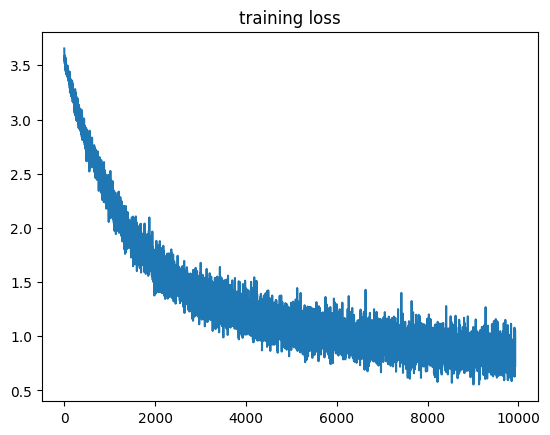

In [32]:
# # Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")

In [33]:
# # Load the best model checkpoint from the 'checkpoint' directory
# checkpoint_path = './checkpoint/weight.t7'
# checkpoint = torch.load(checkpoint_path, map_location=device)

# # If you saved the model's state_dict under the key 'model'
# model.load_state_dict(checkpoint['model'])

## Inference

In [35]:
# --- Define Helper Functions for Prediction ---

def get_likely_index(logits):
    """
    Returns the index of the class with the highest logit.
    """
    # logits is assumed to be of shape [1, num_classes]
    return torch.argmax(logits, dim=1)

def index_to_label(index):
    """
    Converts a class index to its corresponding label string.
    """
    # raw_dataset.class_names is assumed to be a list of labels
    return raw_dataset.class_names[index.item()]

def predict(tensor):
    """
    Given a waveform tensor, this function passes it through the model
    and returns the predicted label.
    """
    # Ensure the tensor is on the correct device
    tensor = tensor.to(device)
    # Add a batch dimension (expected shape: [B, channels, n_mels, time])
    tensor = transform(tensor)
    tensor = tensor.unsqueeze(0)
    # Pass the tensor through the model (assumes model is already defined and on device)
    logits = model(tensor)
    # Get the index with the highest score
    predicted_index = get_likely_index(logits)
    # Convert the index to a label string
    predicted_label = index_to_label(predicted_index.squeeze())
    return predicted_label

# --- Example Usage of predict() ---
# Retrieve a sample from the dataset. Note: Our custom dataset returns (waveform, label_idx)
waveform_transform, label_idx = raw_dataset[2000]
waveform, sample_rate, label, _ , _ = dataset[2000]
# For display purposes, we want to know the expected word label.
expected_label = raw_dataset.class_names[label_idx]

In [36]:
# Play the audio sample. The waveform is a Mel Spectrogram here,
# so if you want to hear the original waveform, use the original dataset instead.
# Here, for demonstration, we assume the sample_rate is 16000.
Audio(waveform.cpu().numpy(), rate=16000)

In [37]:
print(f"Expected: {expected_label}")
print(f"Predicted: {predict(waveform)}")

Expected: bed
Predicted: bed


## Reference
- https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53
- https://github.com/aminul-huq/Speech-Command-Classification